# Контекст

- по тексту title новостных заголовков предсказать категорию новости (Бизнес, Спорт , и т.д.)
- применить предварительно скаченный GloVe вложения (100d)

# Векторизация данных

- вектор: длина ---> длина самого длинного title новостной статьи
- значения в векторе - целые числа отражающие слова из последовательности (индексы словаря)
- также есть 4 доп токена: UNK, MASK, BEGIN-OF-SEQUENCE, END-OF-SEQUENCE
    - UNK для редких слов
    - MASK для выравниваня длины
    - BEGIN-OF-SEQUENCE индикатор начала последовательности
    - BEND-OF-SEQUENCE индикатор конца последовательности


In [1]:
# база
import pandas as pd
import warnings
import numpy as np
import time
import re
import json

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.lm import Vocabulary

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# метрика
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# константы
RANDOM_STATE = 42
warnings.filterwarnings("ignore")
emb_path = 'glove.6B.100d.txt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA ?: ', torch.cuda.is_available())

c:\Users\oudel\anaconda3\envs\newenv\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CUDA ?:  True


In [2]:
data_tr = pd.read_csv('train.csv')
data_ts = pd.read_csv('test.csv')
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [3]:
data_tr['Class Index'].value_counts()

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

In [4]:
data_ts['Class Index'].value_counts()

Class Index
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64

In [5]:
data_tr['split'] = 'train'
data_ts['split'] = 'test'
data = pd.concat([data_tr, data_ts], axis = 0, ignore_index = True)
data = data[['Class Index', 'Title', 'split']]
data = data.rename({'Class Index': 'label', 'Title': 'title'}, axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127600 entries, 0 to 127599
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   127600 non-null  int64 
 1   title   127600 non-null  object
 2   split   127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


# Обработка данных

In [6]:
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [7]:
data['title'] = data['title'].map(preprocess_text)
data['title'].head()

0    wall st . bears claw back into the black reuters 
1    carlyle looks toward commercial aerospace reut...
2        oil and economy cloud stocks outlook reuters 
3    iraq halts oil exports from main southern pipe...
4    oil prices soar to all time record , posing ne...
Name: title, dtype: object

In [8]:
data['label'].value_counts()

label
3    31900
4    31900
2    31900
1    31900
Name: count, dtype: int64

Метки 1-4 --> Понижаем на 1 метки классов (для предотвращения ошибок CUDA)

In [9]:
data['label'] = data['label'].apply(lambda x : x - 1)

In [10]:
data.to_csv('data.csv', index = False)

# Vocabulary

In [11]:
class Vocabulary(object):
    def __init__(self, df, rare_word_count):
        '''  
        df (pd.DataFrame): весь датасет
        rare_word_count (int): количество вхождений токена в тренировочный датасет,
                               при котором, токен считается редки
        '''
        self.df = df
        self.titles = self.df[self.df['split'] == 'train']['title']
        self.rare_word_count = rare_word_count

    def create_vocabs(self):
        # Создание словарей token-index, index-token с дополнительными токенами
        full_train_stroka = ''
        for text in self.titles:
            full_train_stroka += ' ' + text
            
        all_tokens = full_train_stroka.split()
        all_tokens = pd.Series(all_tokens).value_counts().reset_index()
        all_unique_tokens = sorted(all_tokens[all_tokens['count'] > self.rare_word_count]['index'].unique())
        all_unique_tokens = ['<MASK>'] + all_unique_tokens + ['<BEGIN-OF-SEQUENCE>', '<END-OF-SEQUENCE>', '<UNK>']

        self.vocab_token_index = dict(zip(all_unique_tokens,
                                          [int(i) for i in np.arange(0, len(all_unique_tokens))]))
        
        self.vocab_index_token = {}
        for token, index in self.vocab_token_index.items():
            self.vocab_index_token[index] = token
        
        print('Созданы словари с токенами: UNK, MASK, BEGIN-OF-SEQUENCE, END-OF-SEQUENCE')
        print('Длина словарей: {}'.format(len(self.vocab_token_index)))
        print('Индексы дополнительных токенов:\nUNK : {}\nMASK: {}\nBEGIN-OF-SEQUENCE: {}\nEND-OF-SEQUENCE: {}'\
            .format(
            self.vocab_token_index.get('<UNK>'),
            self.vocab_token_index.get('<MASK>'),
            self.vocab_token_index.get('<BEGIN-OF-SEQUENCE>'),
            self.vocab_token_index.get('<END-OF-SEQUENCE>')))
        
        return self.vocab_token_index, self.vocab_index_token
        
    def save_vocabs(self):
        with open('vocab_token_to_index.json', 'w') as file:
                    json.dump(self.vocab_token_index, file)
        with open('vocab_index_to_token.json', 'w') as file:
                    json.dump(self.vocab_index_token, file)
        print('Словари сохранены в открытой директории')
            
    def return_index(self, token):
           return self.vocab_token_index.get(token)
    
    def return_token(self, index):
           return self.vocab_token_index.get(index)
    
    def len(self):
           return len(self.vocab_token_index)

Проверка работоспособности класса Vocabulary

In [12]:
Vocabulary(data, 1).create_vocabs()

Созданы словари с токенами: UNK, MASK, BEGIN-OF-SEQUENCE, END-OF-SEQUENCE
Длина словарей: 20939
Индексы дополнительных токенов:
UNK : 20938
MASK: 0
BEGIN-OF-SEQUENCE: 20936
END-OF-SEQUENCE: 20937


({'<MASK>': 0,
  '!': 1,
  ',': 2,
  '.': 3,
  '?': 4,
  'a': 5,
  'aa': 6,
  'aaa': 7,
  'aachen': 8,
  'aapt': 9,
  'aaron': 10,
  'ab': 11,
  'abandon': 12,
  'abandoned': 13,
  'abandoning': 14,
  'abandons': 15,
  'abare': 16,
  'abb': 17,
  'abbas': 18,
  'abbey': 19,
  'abbott': 20,
  'abc': 21,
  'abcs': 22,
  'abdallah': 23,
  'abdicate': 24,
  'abdicates': 25,
  'abdication': 26,
  'abduct': 27,
  'abducted': 28,
  'abductees': 29,
  'abduction': 30,
  'abductions': 31,
  'abductors': 32,
  'abdullah': 33,
  'abdur': 34,
  'aber': 35,
  'abercrombie': 36,
  'aberdeen': 37,
  'abide': 38,
  'abidjan': 39,
  'abilities': 40,
  'ability': 41,
  'abkhazia': 42,
  'ablaze': 43,
  'able': 44,
  'abn': 45,
  'aboard': 46,
  'aboriginal': 47,
  'aboriginals': 48,
  'aborigines': 49,
  'abortion': 50,
  'aborts': 51,
  'abound': 52,
  'abounds': 53,
  'about': 54,
  'above': 55,
  'abraham': 56,
  'abramovich': 57,
  'abroad': 58,
  'abrupt': 59,
  'abruptly': 60,
  'abs': 61,
  'absa

# Dataset

In [13]:
class NewsDataset(Dataset):
    def __init__(self, df, mode):
        """
        Args:
            df (pandas.DataFrame): датасет
            mode (str): train / test
        """

        self.df_mode = df[df.split == mode]
        # Перемешиваем тренировочный набор
        if mode == 'train':
            self.df_mode = self.df_mode.sample(frac = 1, random_state = RANDOM_STATE)

        self.size_df = len(self.df_mode)
        self.vocabulary = Vocabulary(df, 1)

        # Найдем максимально длинную строку 
        # (добавляем 2 (индикаторы начала и конца BEGIN-OF-SEQUENCE, END-OF-SEQUENCE))
        func_len = lambda text: len(text.split())
        self.max_lenght_text = max(map(func_len, df.title)) + 2

        if mode != 'train':
            with open('vocab_token_to_index.json', 'r') as file:
                self.vocab_token_index = json.load(file)
            with open('vocab_index_to_token.json', 'r') as file:
                self.vocab_index_token = json.load(file)
        else:
            self.vocab_token_index, self.vocab_index_token = self.vocabulary.create_vocabs()
            self.vocabulary.save_vocabs()

    def __len__(self):
        return self.size_df

    def __getitem__(self, index):
        
        row = self.df_mode.iloc[index]
        text = row.title.split()
        self.label = row.label
        self.zeros_vector = np.zeros(self.max_lenght_text, dtype = int)
        self.zeros_vector[0] = self.vocab_token_index.get('<BEGIN-OF-SEQUENCE>')
        for index_in_text, token_in_text in zip(np.arange(len(text)), text):
            try:
                self.zeros_vector[index_in_text+1] = self.vocab_token_index.get(token_in_text)
            except:
                self.zeros_vector[index_in_text+1] = self.vocab_token_index.get('<UNK>')
                
        self.zeros_vector[len(text)+1] = self.vocab_token_index.get('<END-OF-SEQUENCE>')
    
        return row.title, self.zeros_vector, self.label

Проверка работоспособности класса Dataset

In [14]:
train_dataloader = DataLoader(dataset = NewsDataset(df = data,
                                                    mode = 'train'))

train_dataloader.dataset[0]

Созданы словари с токенами: UNK, MASK, BEGIN-OF-SEQUENCE, END-OF-SEQUENCE
Длина словарей: 20939
Индексы дополнительных токенов:
UNK : 20938
MASK: 0
BEGIN-OF-SEQUENCE: 20936
END-OF-SEQUENCE: 20937
Словари сохранены в открытой директории


('bbc set for major shake up , claims newspaper',
 array([20936,  1559, 16527,  7029, 11024, 16583, 19663,     2,  3345,
        12361, 20937,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 2)

# Загрузка вложений GloVe

In [15]:
def load_glove_from_file(glove_filepath):
    ''' 
    Загрузка файла вложений и создание словаря токен-инекс, и списка весов каждого токена
    Args:
        glove_filepath (str): путь к файлу вложений GloVe
    Returns:
        word_to_index (dict), embeddings (np.ndarray)
    '''
    word_to_index = {}
    embeddings = []
    with open(glove_filepath, 'r') as file:
        for index, line in enumerate(file):
            line = line.split(' ')
            # line[0] - это слово из файла вложений GloVe,
            # index - это его номер в файле вложений GloVe 
            # т.е. первая запись в словаре word_to_index --> {'the' : 0}
            word_to_index[line[0]] = index
            embedding_weights = np.array([float(weight) for weight in line[1:]])
            embeddings.append(embedding_weights)
    
    return word_to_index, np.stack(embeddings)

In [16]:
def make_embedding_matrix(glove_filepath, words):
    ''' 
    Создание матрицы вложение для конткретного набора токенов
    Args:
        glove_filepath (str): путь к файлу вложений GloVe
        words (list): список токенов в наших данных
    Returns:
        final_embeddings (np.ndarray): матрица вложений
    '''
    word_to_index_glove, weights_glove_token = load_glove_from_file(glove_filepath)
    embeddings_size = weights_glove_token.shape[1]
    final_embeddings = np.zeros((len(words), embeddings_size))

    for i, word in enumerate(words):
        if word in word_to_index_glove:
            final_embeddings[i, :] = weights_glove_token[word_to_index_glove[word]]
        else:
            not_detected_embedding = torch.ones(1, embeddings_size)
            torch.nn.init.xavier_uniform_(not_detected_embedding)
            final_embeddings[i, :] = not_detected_embedding

    return final_embeddings

# Model

In [17]:
class NewsClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            embedding_size (int): размер векторов вложений (в нашем случае GloVe - 100)
            num_embeddings (int): количество векторов вложений
            filter_width (int): ширина сверточных ядер
            num_channels (int): количество сверточных ядер в каждом слое
            hidden_dim (int): количество нейронов в скрытом слое
            num_classes (int): кол-во классов
            dropout_p (float): вероятность дропаута выхода нейрона
            pretrained_embeddings (numpy.array): предобученные вложения токенов
            padding_idx (int): индекс соответствующей начальной позиции
        """
        super(NewsClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size, # 100
                                    num_embeddings=num_embeddings, # размер словаря
                                    padding_idx=padding_idx) # дополняет индексом до одинаковой длины каждого вектора
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size, # 100
                                    num_embeddings=num_embeddings, # размер словаря
                                    padding_idx=padding_idx, # дополняет индексом до одинаковой длины каждого вектора
                                    _weight=pretrained_embeddings) # веса токенов из GloVe
        
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, out_channels=num_channels,
                      kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3),
            nn.ELU()
        )

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): тензор входных данных  x_in.shape = (batch_size, dataset.max_seq_length)
        Returns:
            итоговый тензор , shape = (batch, num_classes)
        """
        # Слой Вложения + Слои Conv1d
        # вложения и перестановка ---> делаем из признаков каналы
        x_embedded = self.emb(x_in) # на выходе после emb: (128,28,100)
                                    # 128 - размер батча
                                    # 28 - длина самой длинной строки + два доп. токена (начало-конец)
                                    # 100 - кол-во весов в файлах вложений
        x_embedded = x_embedded.permute(0, 2, 1) # (128, 100, 28)
        features = self.convnet(x_embedded) # (128, 100, 3)

        # Слой ПУЛИНГА
        # усреднение и удаление лишнего измерения
        remaining_size = features.size(dim=2) 
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2) # (128, 100)
        features = F.dropout(features, p=self._dropout_p)
        
        # линейный слой
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        return prediction_vector

# Разбор слоев модели и их выходных размеров

# Задаем входные данные из train_dataloader (Размер батча = 128)

In [18]:
x_in = np.zeros((128, 28))
for i in range(0,128):
    values = train_dataloader.dataset[i][1]
    x_in[i] = values

# Входные данные

In [19]:
print('Размерность входных данных: {}'.format(x_in.shape))
print('{} - размер батча\n{} - длина самого длинного предложения (заголовка в нашем случае)\nЧисла внутри вектора - индексы токенов в словаре'.format(x_in.shape[0], x_in.shape[1]))
x_in

Размерность входных данных: (128, 28)
128 - размер батча
28 - длина самого длинного предложения (заголовка в нашем случае)
Числа внутри вектора - индексы токенов в словаре


array([[2.0936e+04, 1.5590e+03, 1.6527e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0936e+04, 1.1182e+04, 1.2340e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0936e+04, 9.7230e+03, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.0936e+04, 3.3500e+02, 1.8653e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0936e+04, 1.5753e+04, 1.1100e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0936e+04, 2.2010e+03, 1.4834e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

# Задаем слой Embedding

In [20]:
# Словари для гиперпараметра num_embeddings
vocab_1, vocab_2 = Vocabulary(data,1).create_vocabs()

Созданы словари с токенами: UNK, MASK, BEGIN-OF-SEQUENCE, END-OF-SEQUENCE
Длина словарей: 20939
Индексы дополнительных токенов:
UNK : 20938
MASK: 0
BEGIN-OF-SEQUENCE: 20936
END-OF-SEQUENCE: 20937


In [21]:
# Веса GloVe (100 признаков на каждый токен)
pretrained_embeddings =\
make_embedding_matrix(glove_filepath = emb_path,
                      words = list(vocab_1))

In [22]:
embedding_size = 100
num_embeddings = len(vocab_1)

# слой Embedding
pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
emb = nn.Embedding(embedding_dim=embedding_size, # 100
                   num_embeddings=num_embeddings, # размер словаря 20937
                   padding_idx=0, # дополняет индексом до одинаковой длины каждого вектора
                   _weight=pretrained_embeddings) # веса токенов из GloVe

In [23]:
output_emb = emb(torch.tensor(x_in, dtype = torch.int))
print('Размерность после слоя Embedding: {}'.format(output_emb.shape))
output_emb

Размерность после слоя Embedding: torch.Size([128, 28, 100])


tensor([[[ 0.0891, -0.2211,  0.0740,  ..., -0.0748,  0.1241,  0.2261],
         [-0.6845, -0.8470,  0.0521,  ...,  0.2294,  0.5838,  0.1643],
         [-0.0270,  0.0054,  0.2293,  ..., -0.5061,  0.2953,  0.1040],
         ...,
         [-0.0893, -0.0723, -0.2104,  ..., -0.0708, -0.1357,  0.1794],
         [-0.0893, -0.0723, -0.2104,  ..., -0.0708, -0.1357,  0.1794],
         [-0.0893, -0.0723, -0.2104,  ..., -0.0708, -0.1357,  0.1794]],

        [[ 0.0891, -0.2211,  0.0740,  ..., -0.0748,  0.1241,  0.2261],
         [-0.4105, -0.1658, -0.2511,  ...,  0.0671, -0.1672,  0.1243],
         [ 0.0040,  0.5327,  0.7005,  ...,  0.9404, -0.2747, -0.0913],
         ...,
         [-0.0893, -0.0723, -0.2104,  ..., -0.0708, -0.1357,  0.1794],
         [-0.0893, -0.0723, -0.2104,  ..., -0.0708, -0.1357,  0.1794],
         [-0.0893, -0.0723, -0.2104,  ..., -0.0708, -0.1357,  0.1794]],

        [[ 0.0891, -0.2211,  0.0740,  ..., -0.0748,  0.1241,  0.2261],
         [ 0.8376,  0.6783,  0.6251,  ...,  0

# Permute (для смены осей)

In [24]:
output_emb = output_emb.permute(0,2,1)
output_emb.shape

torch.Size([128, 100, 28])

# Первый слой Conv1d

In [25]:
conv1 = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, out_channels=100,
                      kernel_size=3),
            nn.ELU()
            )

out_conv1 = conv1(output_emb)
print('Размерность: ', out_conv1.shape)
out_conv1

Размерность:  torch.Size([128, 100, 26])


tensor([[[ 0.1303, -0.2845, -0.1961,  ..., -0.0875, -0.0875, -0.0875],
         [ 0.7255,  0.5487,  0.6826,  ..., -0.1221, -0.1221, -0.1221],
         [-0.1882, -0.1222, -0.1404,  ...,  0.0256,  0.0256,  0.0256],
         ...,
         [ 0.0057,  0.1238, -0.1373,  ..., -0.0727, -0.0727, -0.0727],
         [-0.0380,  0.2695, -0.0665,  ..., -0.0326, -0.0326, -0.0326],
         [ 0.2470,  0.0044,  0.4641,  ...,  0.0675,  0.0675,  0.0675]],

        [[ 0.2278, -0.2118, -0.1607,  ..., -0.0875, -0.0875, -0.0875],
         [ 0.2872,  0.0789,  0.1941,  ..., -0.1221, -0.1221, -0.1221],
         [ 0.0334, -0.1638,  0.1344,  ...,  0.0256,  0.0256,  0.0256],
         ...,
         [-0.0050, -0.1641,  0.1400,  ..., -0.0727, -0.0727, -0.0727],
         [ 0.0188, -0.0806,  0.1346,  ..., -0.0326, -0.0326, -0.0326],
         [-0.2835, -0.2025,  0.2172,  ...,  0.0675,  0.0675,  0.0675]],

        [[-0.0876, -0.2852,  0.1076,  ..., -0.0875, -0.0875, -0.0875],
         [-0.0172,  0.4362,  0.0750,  ..., -0

# Второй слой Conv1d

In [26]:
conv2 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=100, 
                      kernel_size=3, stride=2),
            nn.ELU()
            )

out_conv2 = conv2(out_conv1)
print(out_conv2.shape)
out_conv2

torch.Size([128, 100, 12])


tensor([[[ 0.0948, -0.0083,  0.0636,  ...,  0.0270,  0.0270,  0.0270],
         [-0.0712,  0.1692,  0.0843,  ...,  0.0884,  0.0884,  0.0884],
         [ 0.0980,  0.1076, -0.0075,  ..., -0.0614, -0.0614, -0.0614],
         ...,
         [-0.1698, -0.3156, -0.2187,  ..., -0.0436, -0.0436, -0.0436],
         [ 0.2067, -0.0605,  0.2464,  ..., -0.0282, -0.0282, -0.0282],
         [ 0.1109,  0.5447, -0.0239,  ...,  0.0067,  0.0067,  0.0067]],

        [[ 0.1670, -0.1172,  0.0649,  ...,  0.0270,  0.0270,  0.0270],
         [ 0.1436,  0.1259,  0.0394,  ...,  0.0884,  0.0884,  0.0884],
         [ 0.0199,  0.0997,  0.0489,  ..., -0.0614, -0.0614, -0.0614],
         ...,
         [-0.1524, -0.0323,  0.0109,  ..., -0.0436, -0.0436, -0.0436],
         [ 0.1555, -0.0945,  0.0462,  ..., -0.0282, -0.0282, -0.0282],
         [-0.1360,  0.2028,  0.0699,  ...,  0.0067,  0.0067,  0.0067]],

        [[ 0.0829, -0.0295, -0.2137,  ...,  0.0270,  0.0270,  0.0270],
         [ 0.2075,  0.0971, -0.1267,  ...,  0

# Третий слой Conv1d

In [27]:
conv3 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=100, 
                      kernel_size=3, stride=2),
            nn.ELU()
            )

out_conv3 = conv3(out_conv2)
print(out_conv3.shape)
out_conv3

torch.Size([128, 100, 5])


tensor([[[ 0.0296,  0.0446,  0.0073,  0.0031,  0.0031],
         [-0.0237, -0.0273,  0.0054, -0.0470, -0.0470],
         [-0.0411,  0.1108,  0.1027,  0.0690,  0.0690],
         ...,
         [-0.1738,  0.0209, -0.0022, -0.0393, -0.0393],
         [ 0.2389,  0.1415,  0.0452,  0.0531,  0.0531],
         [-0.0937,  0.0322, -0.0538, -0.0038, -0.0038]],

        [[ 0.1317, -0.0208,  0.0031,  0.0031,  0.0031],
         [ 0.0040, -0.0299, -0.0470, -0.0470, -0.0470],
         [ 0.0474,  0.0950,  0.0690,  0.0690,  0.0690],
         ...,
         [-0.0621, -0.0240, -0.0393, -0.0393, -0.0393],
         [ 0.0362,  0.0726,  0.0531,  0.0531,  0.0531],
         [-0.0095, -0.0195, -0.0038, -0.0038, -0.0038]],

        [[ 0.0175,  0.0561, -0.0072,  0.0031,  0.0031],
         [ 0.1283, -0.1085, -0.0206, -0.0470, -0.0470],
         [ 0.0780,  0.1033,  0.1091,  0.0690,  0.0690],
         ...,
         [-0.1319, -0.0482, -0.0301, -0.0393, -0.0393],
         [ 0.2257,  0.2050,  0.0720,  0.0531,  0.0531],
  

# Четвертый слой Conv1d

In [28]:
conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=100, 
                      kernel_size=3),
            nn.ELU()
            )

out_conv4 = conv4(out_conv3)
print(out_conv4.shape)
out_conv4

torch.Size([128, 100, 3])


tensor([[[-0.0508, -0.0257, -0.0153],
         [ 0.0697, -0.0148, -0.0196],
         [-0.0235,  0.0109,  0.0357],
         ...,
         [-0.0374, -0.0267, -0.0366],
         [ 0.0159,  0.0492,  0.0174],
         [-0.0096,  0.0043,  0.0023]],

        [[ 0.0108, -0.0266, -0.0195],
         [ 0.0185, -0.0102, -0.0049],
         [ 0.0421,  0.0375,  0.0321],
         ...,
         [-0.0591, -0.0363, -0.0358],
         [ 0.0322,  0.0215,  0.0163],
         [ 0.0243,  0.0085,  0.0107]],

        [[-0.0292, -0.0078, -0.0206],
         [ 0.0295, -0.0088, -0.0086],
         [ 0.0107,  0.0068,  0.0365],
         ...,
         [-0.0113, -0.0182, -0.0479],
         [ 0.0320, -0.0054,  0.0161],
         [ 0.0210,  0.0018,  0.0033]],

        ...,

        [[-0.0069, -0.0158, -0.0172],
         [ 0.0207, -0.0234, -0.0079],
         [ 0.0152, -0.0130,  0.0416],
         ...,
         [-0.0339, -0.0142, -0.0456],
         [ 0.0315,  0.0335,  0.0182],
         [-0.0386, -0.0034,  0.0044]],

        [[

# Пулинг усреднения

In [29]:
out_pooling = F.avg_pool1d(out_conv4, 3)
print(out_pooling.shape)
out_pooling

torch.Size([128, 100, 1])


tensor([[[-0.0306],
         [ 0.0117],
         [ 0.0077],
         ...,
         [-0.0335],
         [ 0.0275],
         [-0.0010]],

        [[-0.0118],
         [ 0.0012],
         [ 0.0372],
         ...,
         [-0.0437],
         [ 0.0234],
         [ 0.0145]],

        [[-0.0192],
         [ 0.0040],
         [ 0.0180],
         ...,
         [-0.0258],
         [ 0.0142],
         [ 0.0087]],

        ...,

        [[-0.0133],
         [-0.0035],
         [ 0.0146],
         ...,
         [-0.0312],
         [ 0.0277],
         [-0.0125]],

        [[-0.0057],
         [-0.0222],
         [ 0.0313],
         ...,
         [-0.0441],
         [ 0.0388],
         [ 0.0224]],

        [[-0.0245],
         [-0.0048],
         [ 0.0255],
         ...,
         [-0.0249],
         [ 0.0205],
         [-0.0023]]], grad_fn=<SqueezeBackward1>)

# squeeze(dim = 2)

In [30]:
out_pooling = out_pooling.squeeze(dim = 2)
print(out_pooling.shape)
out_pooling

torch.Size([128, 100])


tensor([[-0.0306,  0.0117,  0.0077,  ..., -0.0335,  0.0275, -0.0010],
        [-0.0118,  0.0012,  0.0372,  ..., -0.0437,  0.0234,  0.0145],
        [-0.0192,  0.0040,  0.0180,  ..., -0.0258,  0.0142,  0.0087],
        ...,
        [-0.0133, -0.0035,  0.0146,  ..., -0.0312,  0.0277, -0.0125],
        [-0.0057, -0.0222,  0.0313,  ..., -0.0441,  0.0388,  0.0224],
        [-0.0245, -0.0048,  0.0255,  ..., -0.0249,  0.0205, -0.0023]],
       grad_fn=<SqueezeBackward1>)

# Dropout (0.3)

In [31]:
out_dropout = F.dropout(out_pooling, 0.3)
print(out_dropout.shape)
out_dropout

torch.Size([128, 100])


tensor([[-0.0437,  0.0168,  0.0110,  ..., -0.0000,  0.0393, -0.0014],
        [-0.0168,  0.0017,  0.0532,  ..., -0.0625,  0.0334,  0.0207],
        [-0.0000,  0.0057,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0050,  0.0209,  ..., -0.0446,  0.0000, -0.0179],
        [-0.0081, -0.0317,  0.0447,  ..., -0.0629,  0.0554,  0.0320],
        [-0.0000, -0.0068,  0.0364,  ..., -0.0356,  0.0293, -0.0034]],
       grad_fn=<MulBackward0>)

# Первый линейный слой + ReLU + Dropout 

In [32]:
lin1 = nn.Linear(in_features = 100, out_features = 100)
out_lin1 = F.relu(F.dropout(lin1(out_dropout), p = 0.3))
print(out_lin1.shape)
out_lin1

torch.Size([128, 100])


tensor([[0.0000, -0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, -0.0000, 0.1068,  ..., -0.0000, 0.0000, 0.0000],
        [0.0193, -0.0000, 0.1157,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0208,  ..., -0.0000, 0.0000, -0.0000],
        [0.0000, 0.0000, 0.0319,  ..., 0.0000, 0.0000, -0.0000],
        [0.0138, -0.0000, 0.0114,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

# Второй линейный слой

In [33]:
lin2 = nn.Linear(100, 4)
out_lin2 = lin2(out_lin1)
print(out_lin2.shape)
out_lin2

torch.Size([128, 4])


tensor([[-0.0374,  0.0002, -0.0409, -0.1260],
        [-0.0956, -0.0042, -0.0249, -0.0960],
        [-0.0706, -0.0647, -0.0284, -0.0698],
        [-0.0403, -0.0090, -0.0535, -0.0710],
        [-0.0650, -0.0089, -0.0381, -0.0770],
        [-0.0383, -0.0443, -0.0526, -0.0608],
        [-0.0755, -0.0388, -0.0657, -0.0536],
        [-0.0231, -0.0455, -0.0645, -0.0786],
        [-0.0785, -0.0219, -0.0652, -0.0747],
        [-0.0546, -0.0162, -0.0431, -0.0855],
        [-0.0907, -0.0205, -0.0605, -0.0799],
        [-0.0821, -0.0365, -0.0693, -0.0759],
        [-0.0856, -0.0478, -0.0632, -0.0444],
        [-0.0435,  0.0078, -0.0457, -0.1126],
        [-0.0428, -0.0460, -0.0484, -0.0772],
        [-0.0605, -0.0376, -0.0563, -0.0851],
        [-0.0443, -0.0236, -0.0285, -0.1008],
        [-0.0696, -0.0220, -0.0346, -0.1146],
        [-0.0766, -0.0173, -0.0379, -0.1134],
        [-0.0425, -0.0365, -0.0332, -0.0967],
        [-0.0566, -0.0255, -0.0600, -0.0557],
        [-0.0552, -0.0436, -0.0939

# Итого

#### Вход
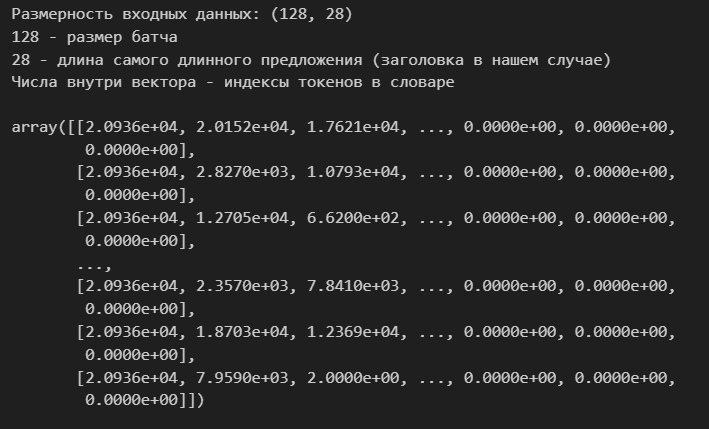

#### Словарь
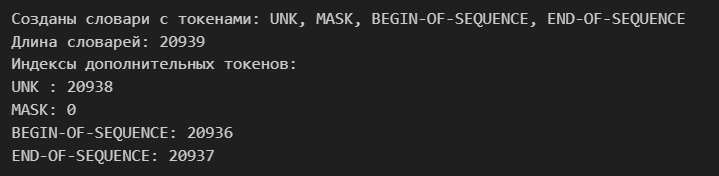

#### Embedding
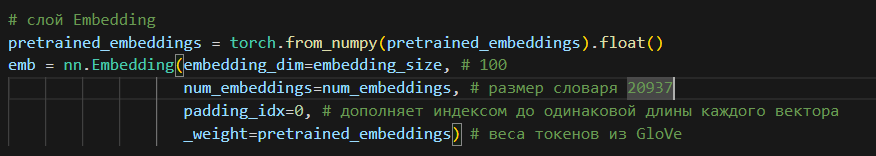
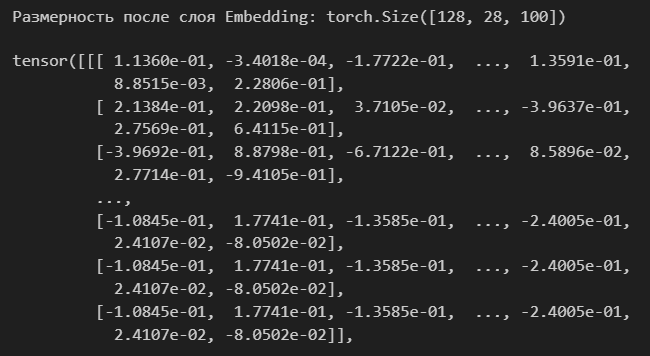

#### Permute
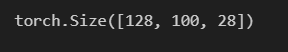

#### 1-й Conv1d
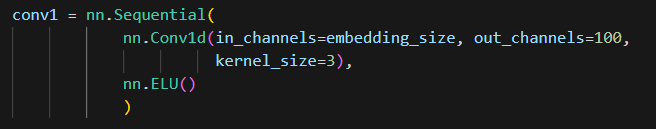
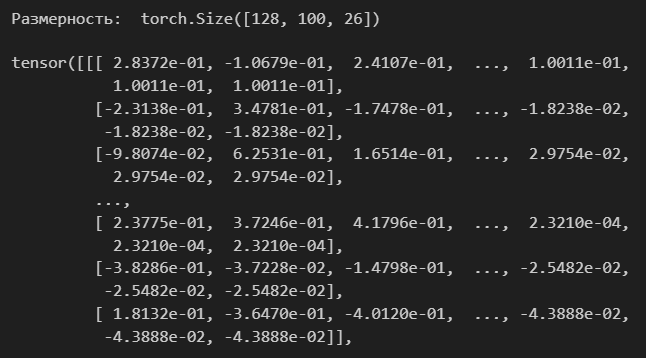

#### 2-й Conv1d
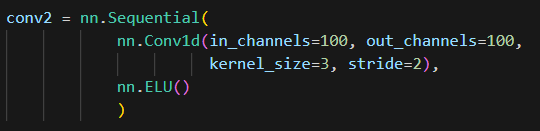
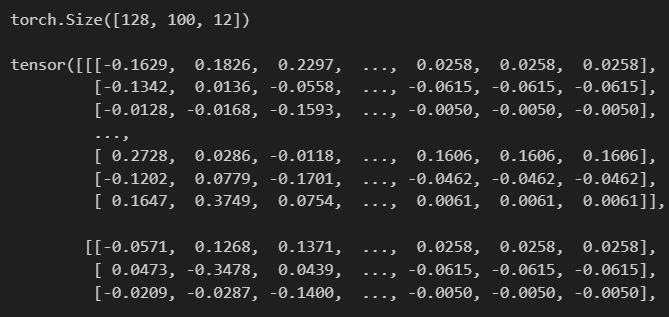

#### 3-й Conv1d
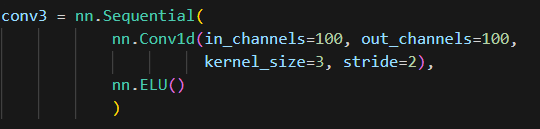
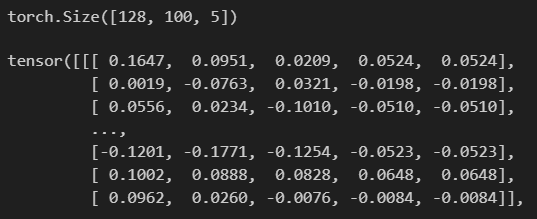

#### 4-й Conv1d
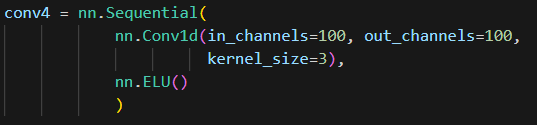
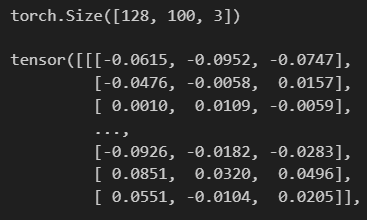

#### Пулинг усреднения
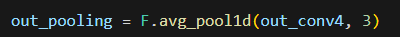
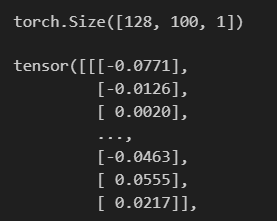

#### squeeze(dim = 2)
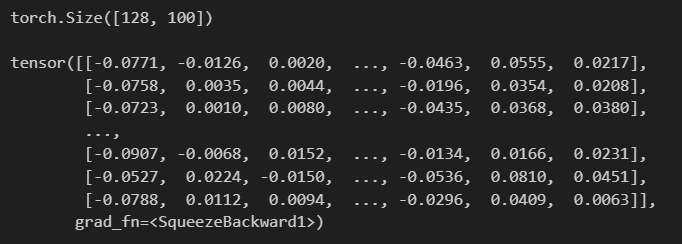

#### Dropout

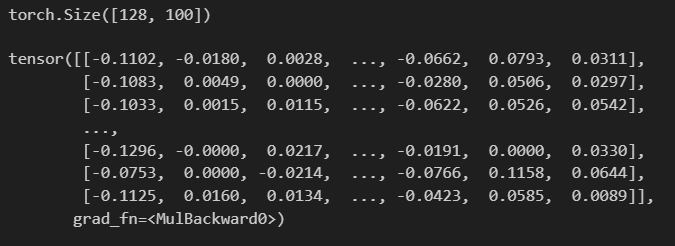

#### Первый линейный слой
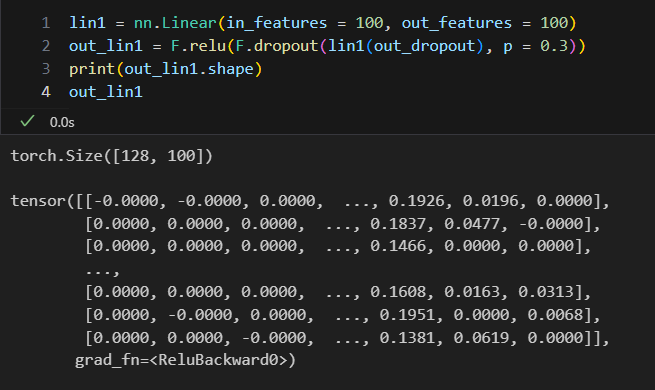

#### Второй линейный слой
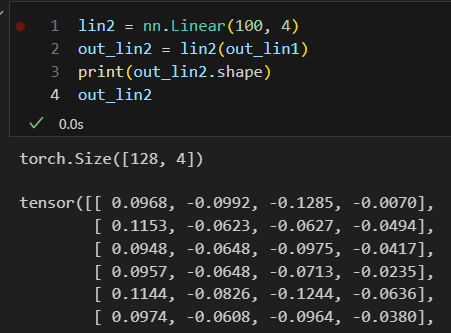

# Функция L1_L2 регуляризация

In [34]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg

# Training loop

In [39]:
def training_loop(
        epoches,
        model,
        optimizer,
        scheduler_append,
        scheduler,
        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        stop_diff_value,

        # verbose
        verbose_epoch
        ):
    
    loss_train_list = []
    loss_val_list = []
    acc_train_list = []
    acc_val_list = []

    model = model.to(device)

    for epoch in range(1, epoches+1):
            
            start_time = time.time()
            loss_train = 0
            loss_val = 0

            correct_train_acc = 0
            correct_val_acc = 0
            total_train_acc = 0
            total_val_acc = 0
            
            for _, features, labels in train_dataloader:
                
                model.train()
                features = features.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer:
                        loss = loss_with_l1_or_l2_regulizer(model = model,
                                                        type = reg_type,
                                                        l_lambda = 0.001,
                                                        loss_by_fn = loss)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()
                
                ########  Расчет тренировочной accuracy  #########
                outputs = torch.softmax(outputs, dim = 1)
                _ , predict_labels = torch.max(outputs,1)
                total_train_acc += labels.size(0)
                correct_train_acc += (predict_labels == labels).sum().item()
                ##################################################

            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)
            train_acc = correct_train_acc / total_train_acc
            acc_train_list.append(train_acc)
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                                for _, features, labels in val_dataloader:
                                        features = features.to(device)
                                        labels = labels.type(torch.LongTensor).to(device)
                                        outputs = model(features)
                                        loss_on_val = loss_fn(outputs, labels)
                                        loss_val += loss_on_val.item()
                                        
                                        ########  Расчет валидационной accuracy  #########
                                        outputs = torch.softmax(outputs, dim = 1)
                                        _ , predict_labels = torch.max(outputs,1)
                                        total_val_acc += labels.size(0)
                                        correct_val_acc += (predict_labels == labels).sum().item()
                                        ##################################################

                                mean_epoch_loss_val = loss_val / len(val_dataloader)
                                loss_val_list.append(mean_epoch_loss_val)
                                val_acc = correct_val_acc / total_val_acc
                                acc_val_list.append(val_acc)
                                
            # EARLY STOPPING #######################################
            if stop_mode:
                if len(loss_train_list) >= each__X__epoch:
                        past = loss_train_list[-each__X__epoch]
                        now = loss_train_list[-1]
                        if (past <= now):

                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
                if len(loss_val_list) >= each__X__epoch:
                        past = loss_val_list[-each__X__epoch]
                        now = loss_val_list[-1]
                        if (past <= now):
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
            ##############################################################
            if scheduler_append:
                scheduler.step(mean_epoch_loss_val)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch ==1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train accuracy: {:.3f} || val accuracy: {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss,
                                mean_epoch_loss_val,
                                train_acc,
                                val_acc
                                )     
                      )
            ################################################################
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_val_list,
                 label = 'val')
    plt.title('Потери от эпох: epoches: {}'.format(epoches))
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = acc_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = acc_val_list,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('accuracy')
    plt.title('accuracy per epoch'.format(epoches))
    plt.legend()
    plt.grid()
    plt.show()
    
    return model

# Задаем некоторые гиперпараметры модели, dataloaders, pretrained_emb , vocabs

In [41]:
# Словари
vocab_token_index, vocab_index_token = Vocabulary(data,1).create_vocabs()
len_vocab = len(vocab_token_index)

# Загруженные веса модели из GloVe
pretrained_embeddings =\
make_embedding_matrix(glove_filepath = emb_path,
                      words = list(vocab_1))


train_dataloader = DataLoader(dataset = NewsDataset(df = data,
                                                    mode = 'train'),
                              batch_size = 128)

test_dataloader = DataLoader(dataset = NewsDataset(df = data,
                                                   mode = 'test'),
                             batch_size = 128)

Созданы словари с токенами: UNK, MASK, BEGIN-OF-SEQUENCE, END-OF-SEQUENCE
Длина словарей: 20939
Индексы дополнительных токенов:
UNK : 20938
MASK: 0
BEGIN-OF-SEQUENCE: 20936
END-OF-SEQUENCE: 20937
Созданы словари с токенами: UNK, MASK, BEGIN-OF-SEQUENCE, END-OF-SEQUENCE
Длина словарей: 20939
Индексы дополнительных токенов:
UNK : 20938
MASK: 0
BEGIN-OF-SEQUENCE: 20936
END-OF-SEQUENCE: 20937
Словари сохранены в открытой директории


Расчетное время выполнения всего цикла 1235.529 минут
Epoch     1/ 5000 || time: 14.826 || train loss: 1.385 || val_loss: 1.383 || train accuracy: 0.273 || val accuracy: 0.306
Epoch    10/ 5000 || time: 14.396 || train loss: 0.529 || val_loss: 0.532 || train accuracy: 0.815 || val accuracy: 0.816
Epoch    20/ 5000 || time: 12.952 || train loss: 0.463 || val_loss: 0.477 || train accuracy: 0.839 || val accuracy: 0.832
Epoch    30/ 5000 || time: 12.943 || train loss: 0.439 || val_loss: 0.455 || train accuracy: 0.846 || val accuracy: 0.840
Epoch    40/ 5000 || time: 13.001 || train loss: 0.419 || val_loss: 0.437 || train accuracy: 0.853 || val accuracy: 0.845
Epoch    50/ 5000 || time: 12.810 || train loss: 0.401 || val_loss: 0.423 || train accuracy: 0.860 || val accuracy: 0.851
Epoch    60/ 5000 || time: 12.863 || train loss: 0.385 || val_loss: 0.411 || train accuracy: 0.867 || val accuracy: 0.857
Epoch    70/ 5000 || time: 13.089 || train loss: 0.371 || val_loss: 0.404 || train accuracy:

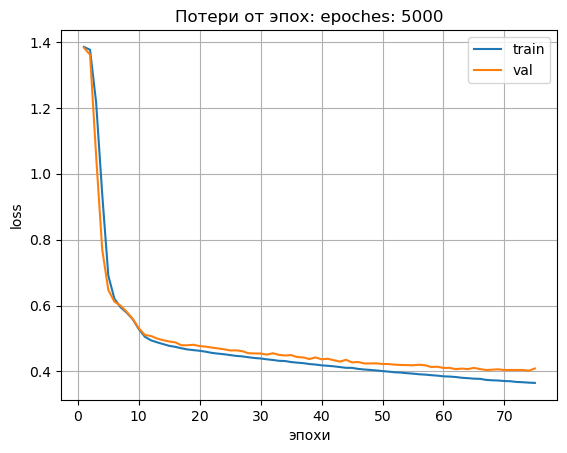

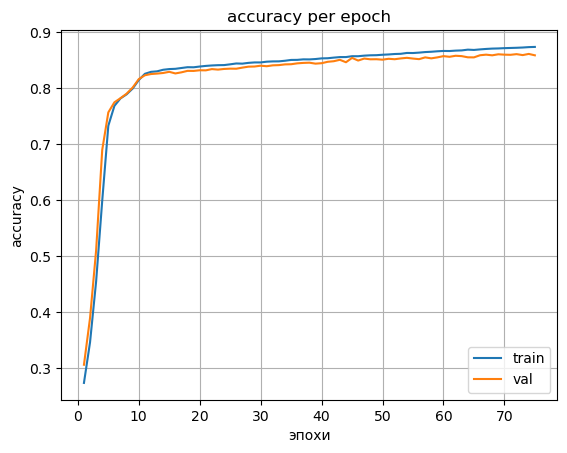

In [43]:
model = NewsClassifier(
    embedding_size = 100,
    num_embeddings = len_vocab,
    num_channels = 100,
    hidden_dim = 100,
    num_classes = 4,
    dropout_p = 0.3,
    pretrained_embeddings = pretrained_embeddings,
    padding_idx = 0
)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 10, factor=0.5, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler_append = False,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = test_dataloader,
    regulizer = False,
    reg_type = 'l1',
    stop_mode = True,
    each__X__epoch = 10,
    stop_diff_value = 0.001,
    verbose_epoch = 10
)